<a href="https://colab.research.google.com/github/AanchalA/PyTorch-Deep-Learning-Bootcamp/blob/main/08_pytorch_ViT_paper_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.0+cu121
torchvision version: 0.20.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 25.52 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Get Data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create Datasets and DataLoaders

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), len(class_names), class_names

(8, 3, 3, ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

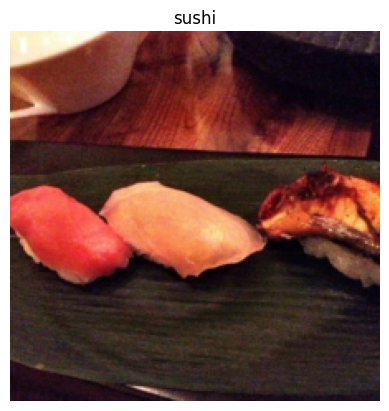

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# ViT Paper Replication

https://arxiv.org/pdf/2010.11929

https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/video_notebooks/08_pytorch_paper_replicating_video.ipynb#scrollTo=KQOfbOBzqcWT

## Equation 1: Split data into patches and create the classes, position and patch embedding

In [ ]:
# Layers = input -> function -> output
# input shape = (224, 224, 3) [single image: Height, width, colour channels]
# output shape = (N, P^2.C) --> (Num patches, embedding dimension D) [N- number of patches (Height * width) / P^2, D=P^2.C, patch_size^2*colour_channels]

height = 224
width = 224
num_channels = 3
patch_size = 16

num_patches = int((height * width) / patch_size**2)

# Input and Output Shapes of a single 2D image
embedding_layer_input_shape = (height, width, num_channels)
embedding_layer_output_shape = (num_patches, patch_size**2 * num_channels)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

### Turning a Single Image into Patches

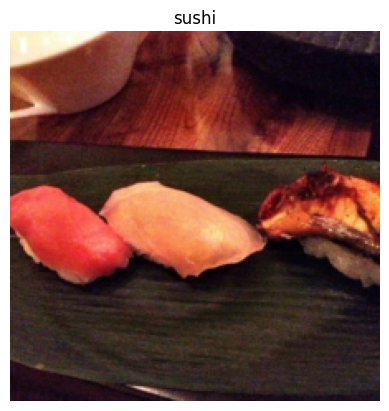

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [ ]:
image.shape

torch.Size([3, 224, 224])

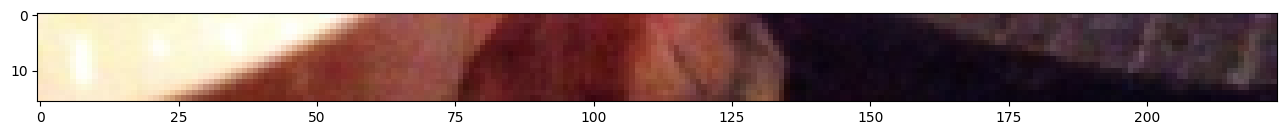

In [ ]:
image_permuted = image.permute(1, 2, 0)             ## for matplotlib

# Index to plot the top row of the image.
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))        ## (16, 16)
plt.imshow(image_permuted[:patch_size, :, :])       ## [H, W, C] - [height upto patch_size, full width, all colour channels]

Number of patches per row: 14.0
Patch Size: 16 pixels X 16 pixels.


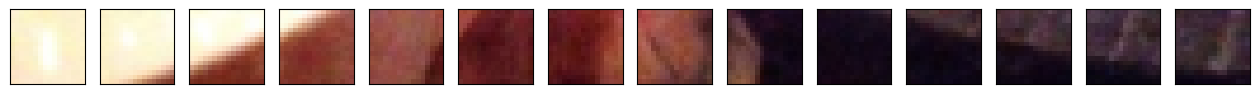

In [ ]:
# Code to plot the top row as pathces

image_size = 224
patch_size = 16
num_patches = image_size / patch_size

assert image_size % patch_size == 0, "Image size must be divisible by patch_size"
print(f"Number of patches per row: {num_patches}")
print(f"Patch Size: {patch_size} pixels X {patch_size} pixels.")

# Creating a series of subplots
fig, ax = plt.subplots(nrows=1,
                       ncols=image_size//patch_size,            ## one column for each patch
                       sharex=True,                             ## Share X and Y axis values
                       sharey=True,
                       figsize=(patch_size,  patch_size))

# Iterate through the number of patches in the top row
for i, patch in enumerate(range(0, image_size, patch_size)):
    ax[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);  # (H - upto patch_size, W - patch: patch : patch + patch_size, C=all)
    ax[i].set_label(i+1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per col: 14.0
Number of total patches: 196.0
Patch Size: 16 pixels X 16 pixels.


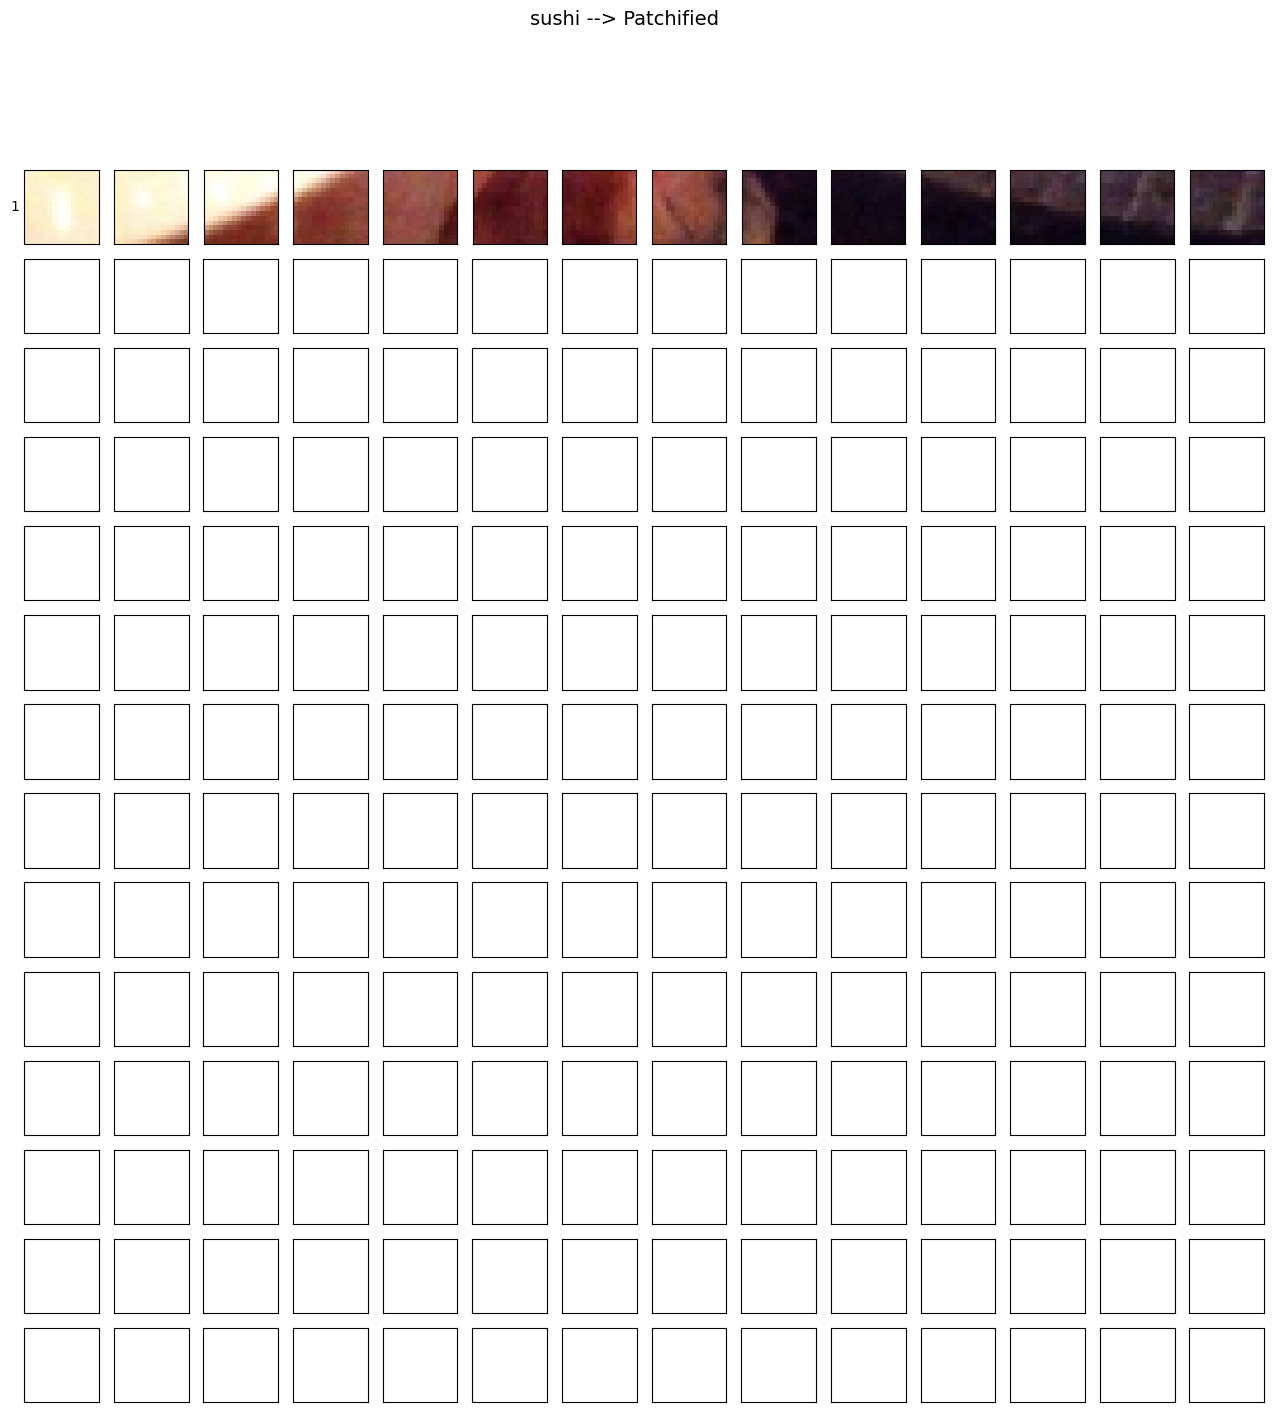

In [ ]:
#  Turing the whole image into patches

image_size = 224
patch_size = 16
num_patches = image_size / patch_size

assert image_size % patch_size == 0, "Image size must be divisible by patch_size"
print(f"Number of patches per row: {num_patches}")
print(f"Number of patches per col: {num_patches}")
print(f"Number of total patches: {num_patches * num_patches}")
print(f"Patch Size: {patch_size} pixels X {patch_size} pixels.")

fig, ax = plt.subplots(nrows=image_size//patch_size,            ## height // patch_size
                       ncols=image_size//patch_size,            ## width // patch_size,  one column for each patch
                       sharex=True,                             ## Share X and Y axis values
                       sharey=True,
                       figsize=(patch_size,  patch_size))

# Iterate through the number of patches in the top row
for i_height, patch_height in enumerate(range(0, image_size, patch_size)):
    for i_width, patch_width in enumerate(range(0, image_size, patch_size)):
        ax[i_height, i_width].imshow(image_permuted[patch_height: patch_height + patch_size,        ## Iterate through height
                                                    patch_width: patch_width + patch_size,          ## Iterate through width
                                                    :]);                                            ## Get all colour channels
        ax[i_height, i_width].set_ylabel(i_height + 1,
                                        rotation="horizontal",
                                        horizontalalignment="right",
                                        verticalalignment="center")
        ax[i_height, i_width].set_xlabel(i_width + 1)
        ax[i_height, i_width].set_xticks([])
        ax[i_height, i_width].set_yticks([])
        ax[i_height, i_width].label_outer()

    fig.suptitle(f"{class_names[label]} --> Patchified", fontsize=14)
    plt.show()

### Creating image into patches and Converting the patches into embeddings

In [ ]:
# Creating the patches and their embeddings using the torch.nn.conv2d, where kernel_size = patch_size, stride = patch_size
# Using a CNN Feature Maps

from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, out_channels=768,         ## Embedding dim = 768 (table 1)
                   kernel_size=patch_size, stride=patch_size, padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
image_out_of_conv = conv2d(image.unsqueeze(dim=0))          ## adding the batch dim
print(image_out_of_conv.shape)
# torch.Size([1, 768, 14, 14])   ---- [ batch_size, embedding_dim, feature_map_height, feature_map_width]

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [647, 738, 288, 489, 490]


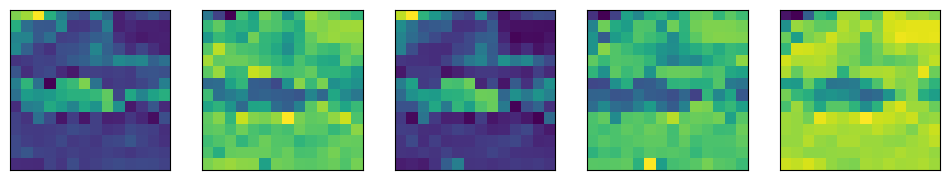

In [ ]:
# Plot random convolutional feature maps (embeddings)
import random

random_indexes = random.sample(range(0, 758), k=5)          ## embedding size 768, taking 758 - leaving room for 10 at the end.
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]  ## index on the output tensor of conv2d layer.
    ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy())         ## remove batch dim, remove grad tracking, convert to numpy
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Get a single feature map in tensor form

single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map.shape, single_feature_map.requires_grad

(torch.Size([1, 14, 14]), True)

In [ ]:
# Flattening the spatial dimensions of the feature map (height and width)
flatten = nn.Flatten(start_dim=2, end_dim=3)

flattened_embeddings = flatten(image_out_of_conv)
print(flattened_embeddings.shape)

torch.Size([1, 768, 196])


Original Image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened Image feature map shape: torch.Size([1, 196, 768])


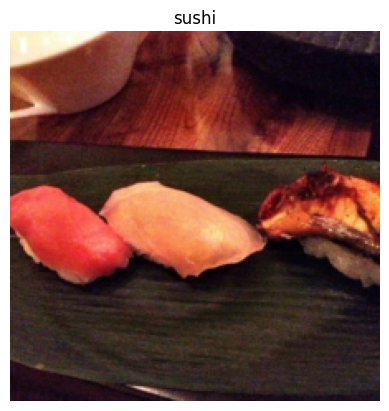

In [ ]:
# Putting everything together

plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

print(f"Original Image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(dim=0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the height and width feature maps to get the number of patches.
flattened_embeddings = flatten(image_out_of_conv)
flattened_embeddings_permuted = flattened_embeddings.permute(0, 2, 1)        ## --[batch_size, num_patches, embedding_dimension]
print(f"Flattened Image feature map shape: {flattened_embeddings_permuted.shape}")

In [ ]:
## Visualize a single flattened feature map
single_feature_map = flattened_embeddings_permuted[:, :, 0]     ## [batch_size, num_patches, embedding_dimension]
single_feature_map.shape

torch.Size([1, 196])

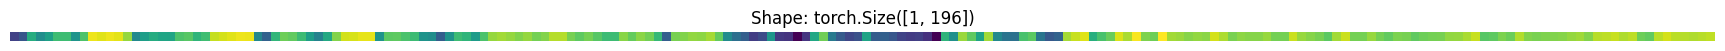

In [ ]:
plt.figure(figsize=(22, 22))
plt.imshow(single_feature_map.detach().numpy())
plt.title(f"Shape: {single_feature_map.shape}")
plt.axis(False);

### Turning ViT Patch Embedding Layer into a PyTorch Module

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, num_channels: int=3,
                 embedding_dims: int=768,
                 patch_size: int=16):

        super().__init__()
        self.patch_size = patch_size
        # Layer to turn the input image into embedded patches.
        self.patcher = nn.Conv2d(in_channels=num_channels,
                                 out_channels=embedding_dims,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # Layer to flatten the feature map outputs of conv2d layer
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        # Assertion to check input image has the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size. Image shape: {image_resolution}, patch size: {self.patch_size}"

        # Forward Pass
        x = self.patcher(x)
        x = self.flatten(x)                     ## [batch_size, embedding_dimension, num_patches]
        x = x.permute(0, 2, 1)                  ## [batch_size, num_patches, embedding_dimension]
        return x

In [ ]:
set_seeds()

# Create instance of embedding layer
patchify = PatchEmbedding(num_channels=3, embedding_dims=768, patch_size=16)

# Pass a single image through the patch embedding layer
print(f"Input Image Size: {image.unsqueeze(dim=0).shape}")            ## unsqueeze - add batch dim to single image
patch_embedded_image = patchify(image.unsqueeze(dim=0))
print(f"Output Patch Embedding Sequence Shape: {patch_embedded_image.shape}")

Input Image Size: torch.Size([1, 3, 224, 224])
Output Patch Embedding Sequence Shape: torch.Size([1, 196, 768])


### Creating the Class Token Embedding
- Prepand a learnable class token to the start of the patch embedding.

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Get the batch size and the embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dims = patch_embedded_image.shape[-1]

print(batch_size, embedding_dims)

1 768


In [ ]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimesion (D).
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dims),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# Add the class token embedding to the front of the patch embedding.
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)        ## num_of_patches dimension
patch_embedded_image_with_class_embedding.shape                     ## [batch_size, class_token + num_patches, embedding_dimension]

torch.Size([1, 197, 768])

### Creating the Position Embeddings

### No position information is being stored here, and these embeddings are just added to the patch embeddings element-wise, How is the model able to learn/optimizer position information from this???

Create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [ ]:
#  View the sequence of patch embeddings with the prepended class embedding

patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
#  Calculate the number of patches (N)
# number_of_patches = int((height * width) / patch_size ** 2) + 1               ## + 1 for class token
number_of_patches = patch_embedded_image_with_class_embedding.shape[1]

#  Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

In [ ]:
# Creating the 1d position embeddings

position_embedding = nn.Parameter(torch.randn(1, number_of_patches, embedding_dimension),
                                  requires_grad=True)

position_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
# Add position embedding to the patch and class token embedding

patch_and_positon_embedding = patch_embedded_image_with_class_embedding + position_embedding          ## Element-wise addition - No change in shape, values get added elementwise.
patch_and_positon_embedding.shape

torch.Size([1, 197, 768])

### Putting it all together: Patch and Position Embeddings

In [ ]:
set_seeds()

# 1. Set the patch size
patch_size = 16


#  2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]


# 3. Get the image tensor and a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")


# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(num_channels=3, embedding_dims=768, patch_size=patch_size)


#  5. Pass input image through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Shape: {patch_embedding.shape}")


# 6. Create the class token embedding
batch_size = patch_embedding.shape[0]
embedding_dims = patch_embedding.shape[-1]

class_token = nn.Parameter(torch.randn((batch_size, 1, embedding_dims)),
                           requires_grad=True)
print(f"Class Token Embedding Shape: {class_token.shape}")


# 7. Prepend the class toeken embedding  to patch embedding.
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding),
                                             dim=1)         ## number of patches dimension
print(f"Patch Embedding with Class Token Shape: {patch_embedding_with_class_token.shape}")


#  8. Create the position embedding
# number_of_patches = int((height * width) / patch_size ** 2) + 1               ## +1 for class token patch
number_of_patches = patch_embedding_with_class_token.shape[1]

position_embedding = nn.Parameter(torch.randn(1, number_of_patches, embedding_dims),
                                  requires_grad=True)


# 9. Add the position embeddings to patch embedding with the class token
patch_and_positon_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_positon_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch Embedding Shape: torch.Size([1, 196, 768])
Class Token Embedding Shape: torch.Size([1, 1, 768])
Patch Embedding with Class Token Shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Updating Patch Embedding Class to Include Class Token Embedding and Position Embedding

In [ ]:
# class PatchEmbedding(nn.Module):
#     def __init__(self, num_channels: int=3,
#                  embedding_dims: int=768,
#                  patch_size: int=16):

#         super().__init__()
#         self.patch_size = patch_size
#         # Layer to turn the input image into embedded patches.
#         self.patcher = nn.Conv2d(in_channels=num_channels,
#                                  out_channels=embedding_dims,
#                                  kernel_size=patch_size,
#                                  stride=patch_size,
#                                  padding=0)

#         # Layer to flatten the feature map outputs of conv2d layer
#         self.flatten = nn.Flatten(start_dim=2, end_dim=3)

#     def forward(self, x):
#         # Assertion to check input image has the correct shape
#         image_resolution = x.shape[-1]
#         assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size. Image shape: {image_resolution}, patch size: {self.patch_size}"

#         # Forward Pass
#         x = self.patcher(x)
#         x = self.flatten(x)                     ## [batch_size, embedding_dimension, num_patches]
#         x = x.permute(0, 2, 1)                  ## [batch_size, num_patches, embedding_dimension]
#         # print(x.shape)

#         # Class Token Embedding
#         batch_size = x.shape[0]
#         embedding_dims = x.shape[-1]
#         class_token = nn.Parameter(torch.randn((batch_size, 1, embedding_dims)),
#                                    requires_grad=True)
#         x = torch.cat((class_token, x), dim=1)         ## number of patches dimension
#         # print(class_token.shape)
#         # print(x.shape)

#         # Position Embeddings
#         # number_of_patches = int((image_height * image_width) / patch_size ** 2) + 1               ## +1 for class token patch
#         number_of_patches = x.shape[1]
#         position_embedding = nn.Parameter(torch.randn(1, number_of_patches, embedding_dims),
#                                         requires_grad=True)
#         x = x + position_embedding
#         # print(position_embedding.shape)
#         # print(x.shape)

#         return x

## Equation 2: MSA (Multi-Head Self Attention) Block

In [ ]:
# Layer Normalization is a technique to normalize the distributions of intermediate layers.
# LayerNorm - Normalizes the values over the D (Embedding) Dimension (Feature Dimension).
# Makes sure that all the samples have the same mean and standard deviation.

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """
    Creates a Multi-Head Self Attention Block (MSA Block)
    """
    def __init__(self,
                 embedding_dims: int=768,           ## Hidden size D from Table 1 (ViT Base)
                 num_heads: int=12,                 ## Heads from Table 1 (ViT Base)
                 attention_dropout: float=0.0
                 ):
        super().__init__()

        # Creating the LayerNorm Layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dims)

        # Creating the multi-head attention layer
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dims,
                                                         num_heads=num_heads,
                                                         dropout=attention_dropout,
                                                         batch_first=True)      ## (batch, seq, features) --> (batch, num_patches, embedding_dimension)

    def forward(self, x):
        x = self.layer_norm(x)
        attention_output, _ = self.multihead_attention(query=x, key=x, value=x,
                                                       need_weights=False)
        return attention_output

In [ ]:
# Creating an instance of the MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims=768, num_heads=12, attention_dropout=0.0)

# Passing the patch and position image embedding sequence through MSA Block.
msa_output = multihead_self_attention_block(patch_and_positon_embedding)
print(f"Input shape of MSA Block: {patch_and_positon_embedding.shape}")
print(f"Output shape of MSA Block: {msa_output.shape}")

Input shape of MSA Block: torch.Size([1, 197, 768])
Output shape of MSA Block: torch.Size([1, 197, 768])


## Equation 3: Multi-Layer Perceptron (MLP Block)

- From section 3.1: **MLP block contains two layers with a GELU non-linearity.**
- GELU: Gaussian Error Linear Unit is a standard gaussian cumulative distribution function that weights inputs by their percentile. GELU can be thought of as a smoother ReLU.

In [ ]:
class MultilayerPerceptronBlock(nn.Module):
    def __init__(self,
                 mlp_size: int=3072,                         ## Number of MLP Hidden Units (from Table 1 - ViT Base)
                 embedding_dims: int=768,
                 dropout: float=0.1):                       ## Value for Dropout available in table 3. Hyaperparameters for training.
        super().__init__()

        # Creating the layerNorm Layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dims)

        # Creating the MLP Layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dims, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dims),
            nn.Dropout(p=dropout))

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# Creating an instance of the MLP block
multilayer_perceptron_block = MultilayerPerceptronBlock(embedding_dims=768, mlp_size=3072, dropout=0.1)

# Passing the output of MSA Block through the MLP Block.
mlp_output = multilayer_perceptron_block(msa_output)
print(f"Input shape of MLP Block: {msa_output.shape}")
print(f"Output shape of MLP Block: {mlp_output.shape}")

Input shape of MLP Block: torch.Size([1, 197, 768])
Output shape of MLP Block: torch.Size([1, 197, 768])


## Transformer Encoder Block
-  The transformer encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3). And there are residual connections between each block.


### Creating a Custom Transformer Encoder Block

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dims: int=768,
                 num_heads: int=12,
                 attention_dropout: float=0.0,
                 mlp_size: int=3072,
                 mlp_dropout: float=0.1
                 ):
        super().__init__()
        self.multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims=embedding_dims,
                                                                          num_heads=num_heads,
                                                                          attention_dropout=attention_dropout)
        self.multilayer_perceptron_block = MultilayerPerceptronBlock(embedding_dims=embedding_dims,
                                                                     mlp_size=mlp_size,
                                                                     dropout=mlp_dropout)

    def forward(self, x):
        x = self.multihead_self_attention_block(x) + x
        x = self.multilayer_perceptron_block(x) + x
        return x

In [ ]:
# Creating an instance of the MSA block
transformer_encoder_block = TransformerEncoderBlock(embedding_dims=768,
                                                    num_heads=12,
                                                    attention_dropout=0.0,
                                                    mlp_size=3072,
                                                    mlp_dropout=0.1)

# Passing the patch and position image embedding sequence through Transformer Encoder Block.
transformer_encoder_output = transformer_encoder_block(patch_and_positon_embedding)
print(f"Input shape of Transformer Encoder Block: {patch_and_positon_embedding.shape}")
print(f"Output shape of Transformer Encoder Block: {transformer_encoder_output.shape}")

Input shape of Transformer Encoder Block: torch.Size([1, 197, 768])
Output shape of Transformer Encoder Block: torch.Size([1, 197, 768])


In [ ]:
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),               ### [batch_size, num_patches, embedding_dims]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)                      [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (multihead_self_attention_block)         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                          [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)                        --                   [1, 197, 768]        2,362,368            True
├─MultilayerPerceptronBlock (multilayer_perceptron_block)              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                          [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp

### Transformer Encoder Layer Using PyTorch Built-In Layers

- `torch.nn.TransformerEncoderLayer`: It is made up of self-attention and feedforward network. (Standard encoder, based on the paper - Attention is all you need.)

In [ ]:
num_heads=12
mlp_size=3072
mlp_dropout=0.1
embedding_dims=768
attention_dropout=0.0

torch_transformer_encoder_layer = torch.nn.TransformerEncoderLayer(d_model=embedding_dims,
                                                                   nhead=num_heads,
                                                                   dim_feedforward=mlp_size,
                                                                   dropout=mlp_dropout,
                                                                   activation="gelu",
                                                                   batch_first=True,
                                                                   norm_first=True)             ## LayerNorm to be done prior to attention and feedforward operations respectively.

print(torch_transformer_encoder_layer)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)


In [ ]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),               ### [batch_size, num_patches, embedding_dims]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## Stacking of the Transformer Encoder Layers to Create the Transformer Encoder Block

In [ ]:
encoder_block = torch.nn.TransformerEncoder(encoder_layer=torch_transformer_encoder_layer,
                                            num_layers=12)
print(encoder_block)

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
summary(model=encoder_block,
        input_size=(1, 197, 768),               ### [batch_size, num_patches, embedding_dims]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─ModuleList (layers)                              --                   --                   --                   True
│    └─TransformerEncoderLayer (0)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─LayerNorm (norm1)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    │    └─MultiheadAttention (self_attn)         [1, 197, 768]        [1, 197, 768]        2,362,368            True
│    │    └─Dropout (dropout1)                     [1, 197, 768]        [1, 197, 768]        --                   --
│    │    └─LayerNorm (norm2)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    │    └─Linear (linear1)                 

## Equation 4: MLP Classification Head

In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self,
                 embedding_dims :int=768,
                 num_classes :int=1000):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dims),
            nn.Linear(in_features=embedding_dims,
                      out_features=num_classes))

    def forward(self, x):
        x = self.classifier(x)
        return x

# Putting It All Together to Create ViT

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self,
                 image_size: int=224,                       ## ViT Paper Table 3
                 in_channels: int=3,
                 patch_size: int=16,
                 num_heads: int=12,                         ## ViT Paper Table 1
                 num_classes: int=1000,
                 mlp_dropout: float=0.1,
                 embedding_dropout: float=0.1,              ## Dropout for patch and position embeddings.
                 embedding_dimension: int=768,              ## ViT Paper Table 1
                 attention_dropout :float=0.0,
                 mlp_hidden_unit_size :int=3072,            ## ViT Paper Table 1 (MLP Size)
                 num_transformer_layers: int=12,            ## ViT Paper Table 1 (Layers)
                 ):
        super().__init__()

        # Make an assertion
        assert image_size % patch_size == 0, f"Image size must be divisible by patch size. Image Size: {image_size}, Patch Size: {patch_size}"

        # Calculate the number of patches = (height * width) / patch_size ^ 2
        self.num_patches = int((image_size * image_size) / patch_size ** 2) + 1

        # Creating Learnable Class Embedding (Will go at the front of the Sequence of the patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dimension),
                                            requires_grad=True)

        # Creating learnable Position Embeddings
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches, embedding_dimension),
                                               requires_grad=True)

        # Create Embedding Dropout Value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Creating the Patch Embedding Layer
        self.patch_embedding = PatchEmbedding(num_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dims=embedding_dimension)

        # Creating the Transformer Encoder Block by Stacking the TransformerEncoder Layers
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dims=embedding_dimension,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_hidden_unit_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])


        # Creating the Classifier Head
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dims),
                                        nn.Linear(in_features=embedding_dims, out_features=num_classes))



    def forward(self, x):
        # Get the Batch Size
        batch_size = x.shape[0]

        # Create the class token embedding and expand it to match the batch size (Equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1)           ## -1 will infer the dimensions.

        # Creating the Patch Embedding (Equation 1)
        x = self.patch_embedding(x)

        # Concatinating Class token and patch embedding
        x = torch.cat((class_token, x), dim=1)          # [batch_size, num_patches, embedding_dim]

        # Add Position Embedding to Patch Embedding
        x = x + self.position_embedding

        # Apply dropout to Patch and Position Embeddings
        x = self.embedding_dropout(x)

        # Pass Patch and Position Embedding through the Transformer Encoder Block (Equation 2 and 3)
        x = self.transformer_encoder(x)

        # Put the 0th Index Logit through the classifier (Equation 4)
        x = self.classifier(x[:, 0])

        return x

In [ ]:
vit = VisionTransformer()
print(vit)

VisionTransformer(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (multihead_self_attention_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (multilayer_perceptron_block): MultilayerPerceptronBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=Tr

In [ ]:
summary(model=vit,
        input_size=(1, 3, 224, 224),               ### [batch_size, colour channels, hegiht, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                                          Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                                            [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                                               [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                                          [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                                         [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                                    [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                                               [1, 197, 768]        [1,

In [ ]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of the ViT Architecture
vit = VisionTransformer(num_classes=len(class_names))

# Pass the random image tensor to the ViT Instance
vit_output = vit(random_image_tensor)

print(f"Random Image Tensor Shape: {random_image_tensor.shape}")
print(f"ViT Output Shape: {vit_output.shape}")
print(f"ViT Output: {vit_output}")

Random Image Tensor Shape: torch.Size([1, 3, 224, 224])
ViT Output Shape: torch.Size([1, 3])
ViT Output: tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)


# Training the Vision Transformer Model

In [ ]:
from helper_functions import plot_loss_curves
from going_modular.going_modular import engine

---
Optimizer Hyperparameters in Paper (Section 4: Training and Fine-Tuning):
- Learning Rate: 10^-3 (0.001 or 1e-3 | all are the same values)
- B1 (Beta 1): 0.9
- B2 (Beta 2): 0.999
- Weight Decay (Regulariztion Parameter | L2 Norm): 0.1

---
The paper does not mention the loss function used.
Since it's a multi-class classification model, we will use Cross Entropy Loss by default.

In [ ]:
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
set_seeds()

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)


loss_fn = torch.nn.CrossEntropyLoss()

# results = engine.train(model=vit,
#                        train_dataloader=train_dataloader,
#                        test_dataloader=test_dataloader,
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=10,
#                        device=device)

# plot_loss_curves(results)

# Using the ViT-Base-16 Model from torch.models

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.5.0+cu121
0.20.0+cu121


In [ ]:
# Getting the per-trained weights for ViT-Base-16 from torchvision
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT            ## Default means the best available weights.

# Setting up the model instance using the loaded pre-trained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 88.6MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Freeze the base parameters
for parameters in pretrained_vit.parameters():
    parameters.requires_grad = False

In [ ]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),               ### [batch_size, colour channels, hegiht, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

In [ ]:
# Updating the Classifier Head (MLP Head): Leaving the features extraction layers as it is, only updating the classification head.
set_seeds()

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),               ### [batch_size, colour channels, hegiht, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Preparing Data for the Pre-Trained ViT Model
- Making sure that the data is formatted in the same way the data the model was trained on.


In [ ]:
# Get the transforms form the Pre-Trained Weights

vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Setting up dataloaders using the above transformations.
from going_modular.going_modular import data_setup

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32,
                                                                                                     )

len(train_dataloader_pretrained), len(test_dataloader_pretrained), len(class_names)

(8, 3, 3)

### Training the Pre-Trained (Feature Exteractor) ViT Model

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


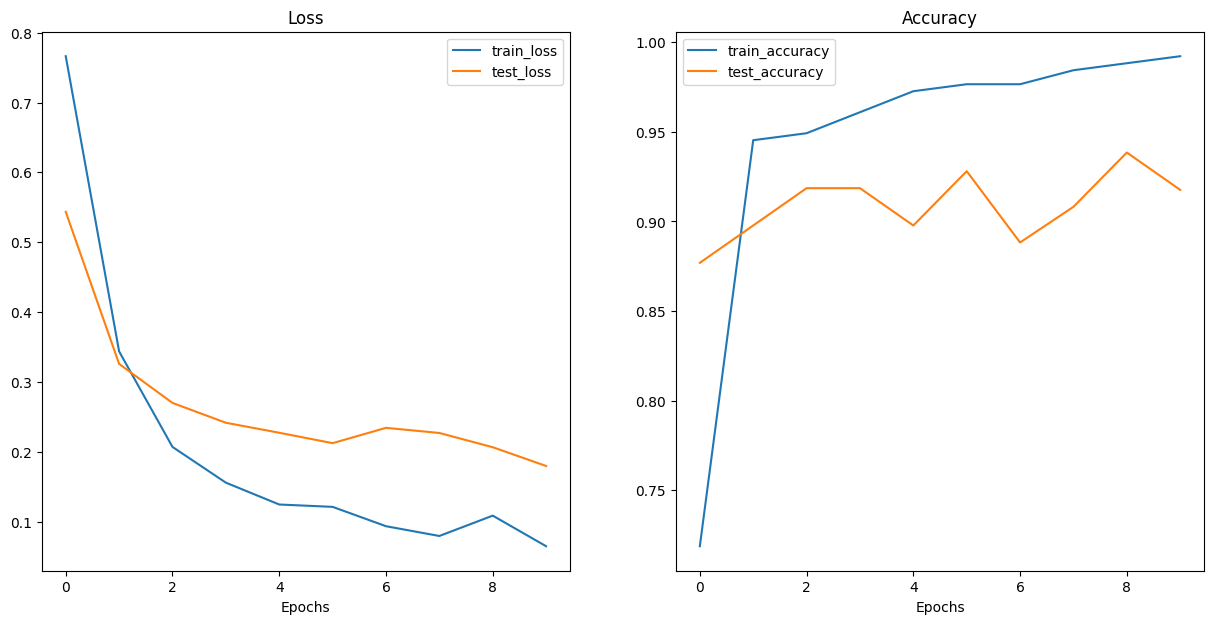

In [ ]:
from helper_functions import plot_loss_curves
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3,
                            #  betas=(0.9, 0.999),
                            #  weight_decay=0.1
                             )


loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

plot_loss_curves(results)

### Saving the Best Performing ViT Model

In [ ]:
from going_modular.going_modular import utils

In [ ]:
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

In [ ]:
from pathlib import Path

# Get the model size in bytes, then convert it to mega-bytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024 * 1024)            ## 1024 part to convert to MB.
print(f"Pretrained ViT Feature Extractor Model Size: {pretrained_vit_model_size} MB")

# Predicting on A Custom Image

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)